In [1]:
# !pip install opencv-python

In [2]:
# #To visualize text in graph
# !pip install scattertext

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


import cv2
import numpy as np
from numpy import argmax
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud # visualization
import os, time
import imageio # use imread function to read the image


import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import tensorflow.keras.backend as K

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tqdm import tqdm
from collections import Counter
from PIL import Image
from itertools import groupby
from tensorflow.keras import initializers
from tensorflow.python.keras.utils.layer_utils import count_params

# import wandb
# from wandb.keras import WandbCallback

### Data Preprocessing

In [2]:
''''
Read the text document and use the text document to generate the path to the images
For all the "ok" status, proceed to generate the text
'''

base_path = "data"
# words_list = []

# words = open(f"{base_path}/words.txt", "r").readlines()

file_path=f"{base_path}/words.txt"
file_path_2=f"{base_path}\\words"
# file_path="../input/iam-handwriting-word-database/words_new.txt"
with open(file_path) as f:
    lines = f.readlines()

label_raw=lines[18:]

image_texts =[]
image_paths =[]

default_path=file_path_2
# default_path="../input/iam-handwriting-word-database/iam_words/words/"
for label in label_raw:
  if label.split()[1]=="ok":
    image_texts.append(label.split()[-1])
    image_paths.append(default_path+"\\"+label.split()[0].split("-")[0]+"\\"+label.split()[0].split("-")[0]+"-"+label.split()[0].split("-")[1]+"\\"+label.split()[0]+".png")

In [3]:
#Print the total size of the images (paths) and labels (texts)
print("Length of image_texts", len(image_texts))
print("Length of image_paths", len(image_paths))

Length of image_texts 96456
Length of image_paths 96456


In [4]:
image_paths[1]

'data\\words\\a01\\a01-000u\\a01-000u-00-01.png'

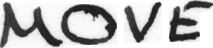

Label: MOVE
Image_1 shape(height, width, channel): (48, 213, 1)
Image_1 data type: <dtype: 'uint8'>


In [6]:
#Using one example to learn about the image and data structure 
display(load_img(image_paths[1]))
print("Label:", image_texts[1])
img_1_raw = tf.io.read_file(image_paths[1])
img_1 = tf.image.decode_image(img_1_raw)
# print(img_1)
print('Image_1 shape(height, width, channel):', img_1.shape)
print('Image_1 data type:', img_1.dtype)
#img_1.shape shows height and weight

In [7]:
# understand the image shape and channel using the imageio imread function
im = imageio.imread(image_paths[1])
print('Image Shape', im.shape)

Image Shape (48, 213)


In [8]:
#Check for any corrupted images
corrupt_images = []

for path in image_paths:
    try:
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
    except:
        corrupt_images.append(path)

In [81]:
# Two corrupted images identified
corrupt_images, len(corrupt_images)

(['data\\words\\a01\\a01-117\\a01-117-05-02.png',
  'data\\words\\r06\\r06-022\\r06-022-03-05.png'],
 2)

In [10]:
# identify the index of the corrupted image
corrupt_index_1 = image_paths.index('data\\words\\a01\\a01-117\\a01-117-05-02.png')
print(corrupt_index_1)

# remove the first corrupted image path and text (label): 'data\\words\\a01\\a01-117\\a01-117-05-02.png'
del image_paths[3600]
del image_texts[3600]

3600


In [11]:
# identify the index of the corrupted image
corrupt_index_2 = image_paths.index('data\\words\\r06\\r06-022\\r06-022-03-05.png')
print(corrupt_index_2)

# remove the first corrupted impage:'data\\words\\r06\\r06-022\\r06-022-03-05.png'
del image_paths[94928]
del image_texts[94928]

94928


In [82]:
# Remaining data
print("Remaing Length of image_texts", len(image_texts))
print("Remaing Length of image_paths", len(image_paths))

Remaing Length of image_texts 96454
Remaing Length of image_paths 96454


### Data Exploration

In [83]:
# Extract the texts from the image_texts list
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels

labels_cleaned = clean_labels(image_texts)

#print the first two clean labels
labels_cleaned[:5]

['A', 'MOVE', 'to', 'stop', 'Mr.']

In [84]:
# Find out the number of unique labels
unique_labels =set(labels_cleaned)
print("The count of unique labels is", len(unique_labels))

The count of unique labels is 12214


In [85]:
longest_text = ''
length_text =0
for txt in labels_cleaned:
    if len(txt)>length_text:
        length_text=len(txt)
        longest_text= txt
    
print("The longest text in the labels is:", longest_text,', with a total length of', length_text)

The longest text in the labels is: plate-and-corrugation , with a total length of 21


#### There are 12,214 unique text labels in the dataset.  We can develop a model to predict by each whole label.  Alternatively, we can treat each label as a combination of the letters and symbols, and train a model to identify the underlying letters and symbols.

Let's find out what the total count of the underlying letters and symbols that are common to our text labels

#### Build a vocabulary of all the unique texts in our dataset

In [86]:
# get vocabulary for the current dataset
vocab = set("".join(map(str, image_texts)))
print('The list of common letters and symbols in our labels are:\n', sorted(vocab))

#get the max length of any text
max_label_len = max([len(str(text)) for text in image_texts])
print("\nThe max length of the labels is", max_label_len)
print("\nThe total count of the common letters and symbols is ", len(vocab))

The list of common letters and symbols in our labels are:
 ['!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

The max length of the labels is 21

The total count of the common letters and symbols is  78


#### Compared to the 12,214 unque text labels, there are only 78 uniqe letters and symbols underlying all labels.   It may be much more efficient to train a model to recognize the letters and symbols that form a text.  The model may generalize better as well.

In [87]:
#Indentify the most popular texts or symbols
label_dict = {}
for x in labels_cleaned:
    if x in label_dict:        
        label_dict[x] += 1
    else:
        label_dict[x] = 1
sorted_label_dict = {key: value for (key, value) in sorted(label_dict.items(), key=lambda x: x[1], reverse=True)}
most_popular_15 = list(sorted_label_dict.keys())[:15]
# most_popular_15
df_dict = pd.DataFrame(sorted_label_dict.items())
df_dict.columns=['Text', "Count"] 
df_dict['Percent_total'] = df_dict['Count']/df_dict['Count'].sum()*100 
df_dict_top_30 = df_dict[:30]

### Show the top 30 most popular texts

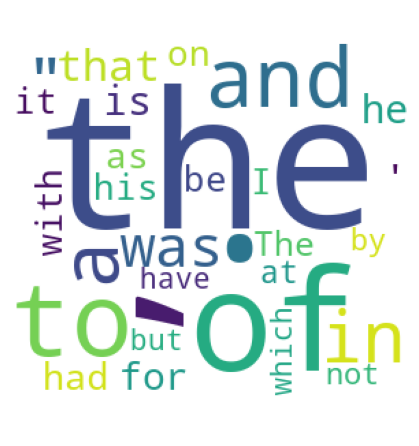

In [102]:
word_could_dict = label_dict
mask = np.array(Image.open("..\\w207_Projects\\note.JFIF"))
wordcloud = WordCloud(width = 1000, height = 500, max_words=30, mask=mask, 
                      background_color='white').generate_from_frequencies(word_could_dict)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud)
# plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)

# store to file
plt.savefig("top_30.png", format="png")
plt.show()

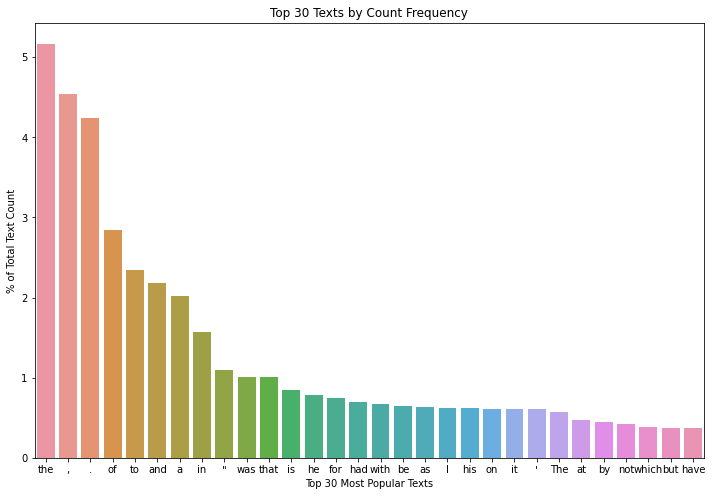

In [253]:
plt.figure(figsize=(12,8))
ax = sns.barplot(x = df_dict_top_30['Text'],
            y = df_dict_top_30['Percent_total'],
            data = df_dict_top_30)
ax.set(xlabel='Top 30 Most Popular Texts', ylabel='% of Total Text Count')
plt.title("Top 30 Texts by Count Frequency")
plt.show(

#### Function to encode the labels, and function to inverse encoding back to text label

In [25]:
char_list = sorted(vocab)


def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
    #pad_sequences will fill in digit 78 (len(char_list)) to reach the max length of len(char_list) for each text label
    return pad_sequences([dig_lst], maxlen=max_label_len, padding='post', value=len(char_list))[0]

def inverse_encode(dig_y):
    word=""
    for i in range(len(dig_y)):
        # 21 elements in each encode_to_labels
        for j in range(21):
            if dig_y[i][j]!=78:
                char = char_list[dig_y[i]]
                word+=char
    return word

In [26]:
padded_image_texts = list(map(encode_to_labels, image_texts))

padded_image_texts[1]

array([38, 40, 47, 30, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78,
       78, 78, 78, 78])

In [ ]:
# # use 90/10 train/test split to speed up training time

# train_image_paths = image_paths[ : int(len(image_paths) * 0.90)]
# train_image_texts = padded_image_texts[ : int(len(image_texts) * 0.90)]

# val_image_paths = image_paths[int(len(image_paths) * 0.90) : ]
# val_image_texts = padded_image_texts[int(len(image_texts) * 0.90) : ]

# #validate
# len(image_paths) ==len(val_image_paths)+len(train_image_paths)

A
(27, 51)


---------------------------
MOVE
(213, 48)


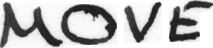

---------------------------
to
(70, 50)


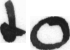

---------------------------
stop
(166, 78)


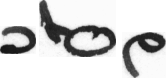

---------------------------
The max width of all images is: 213 
The max height of all images is: 78


In [121]:
#show the first five images
max_img_width = 0
max_img_height = 0

for i in range(4):
    image = image_paths[i]
    label = image_texts[i]
    print(label)
    size = load_img(image).size
    if size[0] > max_img_width:
        max_img_width = size[0]
    if size[1] > max_img_height:
        max_img_height = size[1]
    print(size)
    display(load_img(image))
    print("---------------------------")
print("The max width of all images is:", max_img_width, "\nThe max height of all images is:", max_img_height)

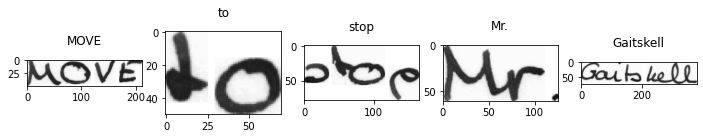

In [157]:
#1 Display 5 images with true label "shirt", but predicted label "coat" (false negatives for the "shirt" class).
def plot_images(image_paths, image_texts, index):
    """
    Display a number of images
    """
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,10))
    
    for i in range(index):
        image = image_paths[i+1]
        label = image_texts[i+1]
        size = load_img(image).size
        label_name = label
        axs[i].imshow(load_img(image))
        axs[i].set_title(label_name, y=1, pad=15)
#         axs[i].axis('off')
    plt.show()    
  
plot_images(image_paths, image_texts, 5)

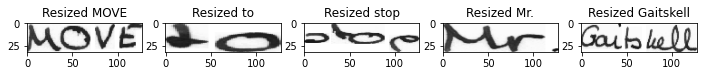

In [156]:
# resize to target size of 32 (height) and 128 (width) to standalize the image size

def resize_display_img(image_paths, image_texts, index):
    """
    Resize and display a number of images
    """
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,10))    
    for i in range(index):
        image = image_paths[i+1]
        label = image_texts[i+1]
        label_name = "Resized " + label
        axs[i].imshow(load_img(image,target_size=(32,128)))
        axs[i].set_title(label_name)
#         axs[i].axis('off')
    plt.show()    
resize_display_img(image_paths, image_texts, 5)

In [30]:
img = load_img(image_paths[4],target_size=(32, 128))
      
# transform image to array
img = img_to_array(img)

# stack images and trasnform to array
# images_stact = np.stack(images_mini)
y_lab = np.array(padded_image_texts[1]).flatten() 
y_lab

array([38, 40, 47, 30, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78,
       78, 78, 78, 78])

In [31]:
len(padded_image_texts)

96454

In [32]:
def preprocess_data_part1(IMAGE_PATH, LABEL_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    LABEL_PATH (str): path to directory with labels.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 224, 224, 3)
    y_mini (np.ndarray): Labels of shape (N,)    
    """
    y_update = []
    images_update = []

    # create lists of images and labels `images_mini` and `y_mini` 
    # based on temp_no_refer and temp_refer selections
    for img in IMAGE_PATH:
        # read image
        img = load_img(image_paths[4],target_size=(32, 128))
        
        # transform image to array
        img = img_to_array(img)
        
        # append to images
        images_update.append(img)

    # stack images and trasnform to array
    images_update = np.stack(images_update)
#     y_update = np.array(LABEL_PATH).flatten()
    y_update = np.array(LABEL_PATH)  # did not flatten as it is multi output (21) for each label 
    
    return images_update, y_update

In [33]:
# generate images and labels based on preprocess_data_part1() function
images_update, y_update = preprocess_data_part1(image_paths, padded_image_texts)

print(f"images_update shape {images_update.shape}")
print(f"y_update shape {y_update.shape}")

images_update shape (96454, 32, 128, 3)
y_update shape (96454, 21)


In [34]:
def process_single_sample(img_path, label):

    # 1. Read image
    img = tf.io.read_file(img_path)

    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)

    # 3. Convert to float32 i+n [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)

    # 4. Resize to the desired size
    img = tf.image.resize(img, [32, 128])
    
#     img = tf.transpose(img, perm=[1, 0, 2])
    return {"image": img, "label": label}

In [52]:
images_update[1].shape

(32, 128, 3)

### Preprocessing: Image transformation and augmentation

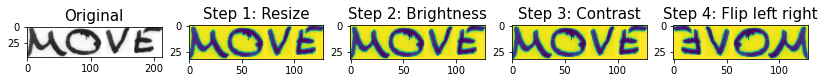

In [36]:
# use one example
tf.random.set_seed(1234)

fig = plt.figure(figsize=(14, 12))

# pull first image from data
image = load_img(image_paths[1])

# plot original
ax = fig.add_subplot(1, 5, 1)
ax.imshow(image)
ax.set_title('Original', size=15);

#test the image transformation
img_io = tf.io.read_file(image_paths[1])

# # 2. Decode and convert to grayscale
img_io = tf.io.decode_png(img_io, channels=1)

# 3. Convert to float32 in [0, 1] range
img_io = tf.image.convert_image_dtype(img_io, tf.float32)

# resize
ax = fig.add_subplot(1, 5, 2)
img_resize = tf.image.resize(img_io, size=(32, 128))
ax.imshow(array_to_img(img_resize))
ax.set_title('Step 1: Resize', size=15);

# adjust brightness
ax = fig.add_subplot(1, 5, 3)
img_bright = tf.image.adjust_brightness(img_resize, 0.3)
ax.imshow(array_to_img(img_bright))
ax.set_title('Step 2: Brightness', size=15);


# adjust contrast
ax = fig.add_subplot(1, 5, 4)
img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
ax.imshow(array_to_img(img_contrast))
ax.set_title('Step 3: Contrast', size=15);


# flip left right
ax = fig.add_subplot(1, 5, 5)
img_flip = tf.image.flip_left_right(img_contrast)
ax.imshow(array_to_img(img_flip))
ax.set_title('Step 4: Flip left right', size=15);

In [ ]:
# # same function but applies to the entire image path
# def process_group_sample(image_path):
    
#     img_path = []

#     for i in range(len(image_path)):
#         img = tf.io.read_file(image_path[i])

#         # 2. Decode and convert to grayscale
#         img = tf.io.decode_png(img, channels=1)

#         # 3. Convert to float32 in [0, 1] range
#         img = tf.image.convert_image_dtype(img, tf.float32)

#         # 4. Resize to the desired size
#         img = tf.image.resize(img, [32, 128])
    
#         img_path.append(img)
#         #     print(img_path)
#     return img_path

In [53]:
IMAGE_SIZE = (32, 128)
CONTRAST_FACTOR = 3
DELTA = 0.3

def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; apply transformaions and augmentations
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)  # need to update the shape
    y (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    
    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to 
    # the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, y = images[shuffle], y[shuffle]
    
    splits = np.multiply(len(images_update), split).astype(int)
    X_train, X_val, X_test = np.split(images_update, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y_update, [splits[0], splits[0]+splits[1]])
    
    ## image transformation on training, validation, and test data ###
    ##################################################################
#     image resize (if the resize is different than (32, 128))
#     X_train = tf.image.resize(X_train, size=IMAGE_SIZE)
#     X_val = tf.image.resize(X_val, size=IMAGE_SIZE)
#     X_test = tf.image.resize(X_test, size=IMAGE_SIZE)
    
    # rescale image to [0,1], i.e., greyscale
    X_train = tf.image.rgb_to_grayscale(X_train)/255.0
    X_val = tf.image.rgb_to_grayscale(X_val)/255.0
    X_test = tf.image.rgb_to_grayscale(X_test)/255.0
    
    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm = tf.image.adjust_brightness(X_train, delta=DELTA)
    
    # adjust contrast
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

    # random flip
    X_train_augm = tf.image.random_flip_left_right(X_train_augm)
    
    # concatenate original X_train and augmented X_train data
    # double the training size in this step
    X_train = tf.concat([X_train, X_train_augm],axis=0)
    
    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    
    return X_train, y_train, X_val, y_val, X_test, y_test

### In the preprocess_data_part2 step, X_train size is double from 57872 to 115744, to include the X_train_augm data

In [54]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_update,
    y_update,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (115744, 32, 128, 1)
y_train shape (115744, 21)
X_val shape (19290, 32, 128, 1)
y_val shape (19290, 21)
X_test shape (19292, 32, 128, 1)
y_test shape (19292, 21)


In [124]:
y_train[0]

array([55, 56, 52, 71, 59, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78,
       78, 78, 78, 78])

#### one-hot encoding the label data

In [108]:

# define input string
data = 'hello world'
print(data)
# define universe of possible input values
alphabet = 'abcdefghijklmnopqrstuvwxyz '
# define a mapping of chars to integers
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))
# integer encode input data
integer_encoded = [char_to_int[char] for char in data]
print(integer_encoded)
# one hot encode
onehot_encoded = list()
for value in integer_encoded:
	letter = [0 for _ in range(len(alphabet))]
	letter[value] = 1
	onehot_encoded.append(letter)
print(onehot_encoded)
# invert encoding
inverted = int_to_char[argmax(onehot_encoded[0])]
print(inverted)

hello world
[7, 4, 11, 11, 14, 26, 22, 14, 17, 11, 3]
[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
h


## Experiment Keras the fully-connected (dense) deep Neural Network Model

In [57]:
def build_model(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='Adam',
                learning_rate=0.01):
    """Build a multi-class logistic regression model using Keras.
    Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.
    Returns:
    model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    
    # firs5t layer: input shape of the dataset
    input1 = keras.layers.Input(shape=(32, 128, 1), name='Input')
    
    # second layer: flatten to transforms the format of the images to a 1D array of 28*28 = 784 pixels
    # this layer has no params or weights to learn, it only reformats data
    input2 = keras.layers.Flatten(name='Flatten')(input1)
    
    # add layers based on hidden_layer_sizes
    inputs_layer = input2
    activation = activation
    for i in range(len(hidden_layer_sizes)):
        input = keras.layers.Dense(hidden_layer_sizes[i], activation = activation, name=f'Hidden_Layer_{i}')(inputs_layer)
        inputs_layer = input  
  
    # next layer: dropout. Makes it so some of the nodes in a given layer don’t pass on their information to the next layer
    input_dropout = keras.layers.Dropout(rate=0.3, name='Dropout')(inputs_layer) 
    
    #the last layer is the output layer
    out = keras.layers.Dense(units=n_classes, activation= None, name='Layer_output')(input_dropout)
    
    # Alternative:  out = keras.layers.Dense(units=n_classes, activation='softmax', name='Layer_output')(input_dropout) 
    # if activation is set to "softmax", then take out (from_logits=True) in the model.compile function
    
    model = keras.models.Model(inputs=input1, outputs=out)
   
    if optimizer=='SGD':
        optimizers = keras.optimizers.SGD(learning_rate=0.01)
    elif optimizer=='Adam':
        optimizers = keras.optimizers.Adam(learning_rate=0.01)
    else:
        raise ValueError('Invalid optimizer: %s' % optimizer)
    
    model.compile(
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        optimizer=optimizers,
        metrics=['accuracy'])
    
    return model

In [59]:
#show model summmary
# model = build_model(n_classes = 21, hidden_layer_sizes=[2048, 1024,512, 256,64])
model = build_model(n_classes = 21, hidden_layer_sizes=[2048,1024,256])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 32, 128, 1)]      0         
                                                                 
 Flatten (Flatten)           (None, 4096)              0         
                                                                 
 Hidden_Layer_0 (Dense)      (None, 2048)              8390656   
                                                                 
 Hidden_Layer_1 (Dense)      (None, 1024)              2098176   
                                                                 
 Hidden_Layer_2 (Dense)      (None, 256)               262400    
                                                                 
 Dropout (Dropout)           (None, 256)               0         
                                                                 
 Layer_output (Dense)        (None, 21)                5397  

In [60]:
X_train.shape

TensorShape([115744, 32, 128, 1])

In [61]:
X_train_mini = np.array(X_train[:8000])
y_train_mini = np.array(y_train[:8000])

In [62]:
tf.random.set_seed(1234)
np.random.seed(1234)

history_img= model.fit(x=X_train,
                y=y_train,
                validation_split=0.1, # set 10% of train data for validation
                batch_size=1000,
#                 batch_size=len(X_train),
                epochs=5,
#                 verbose=0  # fit quitely 
               )

Epoch 1/5
105/105 [==============================] - 16s 144ms/step - loss: 2010891681792.0000 - accuracy: 0.0281 - val_loss: 7727106490368.0000 - val_accuracy: 0.0238
Epoch 2/5
105/105 [==============================] - 15s 142ms/step - loss: 64764004794368.0000 - accuracy: 0.0274 - val_loss: 118257495310336.0000 - val_accuracy: 0.0238
Epoch 3/5
105/105 [==============================] - 15s 144ms/step - loss: 390339814752256.0000 - accuracy: 0.0281 - val_loss: 513365193523200.0000 - val_accuracy: 0.0238
Epoch 4/5
105/105 [==============================] - 15s 144ms/step - loss: 1227051084283904.0000 - accuracy: 0.0277 - val_loss: 1351199798329344.0000 - val_accuracy: 0.0238
Epoch 5/5
105/105 [==============================] - 15s 144ms/step - loss: 2789928345796608.0000 - accuracy: 0.0278 - val_loss: 2804622234222592.0000 - val_accuracy: 0.0238


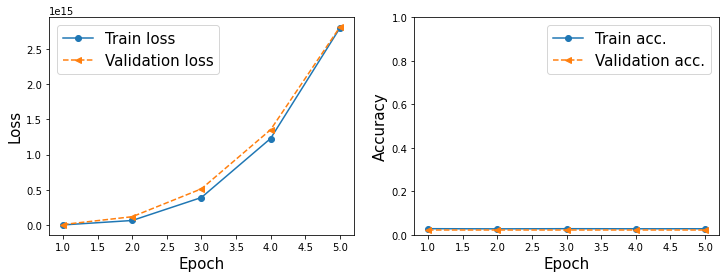

In [63]:
hist_img = history_img.history
x_arr_img = np.arange(len(hist_img['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr_img, hist_img['loss'], '-o', label='Train loss')
ax.plot(x_arr_img, hist_img['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr_img, hist_img['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr_img, hist_img['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0,1)
plt.show()

In [64]:
test_accuracy = model.evaluate(x=X_test, y=y_test, verbose=0, return_dict=True)['accuracy']
test_accuracy

0.013580759055912495

In [69]:
model.predict(X_train[0:1])

1/1 [==============================] - 0s 18ms/step


array([[1.2068078e+15, 1.2069661e+15, 1.2087865e+15, 1.2070334e+15,
        1.2057870e+15, 1.2087321e+15, 1.2089419e+15, 1.2097644e+15,
        1.2081975e+15, 1.2083713e+15, 1.2098868e+15, 1.2094597e+15,
        1.2075764e+15, 1.2088008e+15, 1.2096916e+15, 1.2095792e+15,
        1.2087408e+15, 1.2085049e+15, 1.2082450e+15, 1.2088238e+15,
        1.2082452e+15]], dtype=float32)

In [66]:
y_train[0:2]

array([[55, 56, 52, 71, 59, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78,
        78, 78, 78, 78, 78],
       [53, 56, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78,
        78, 78, 78, 78, 78]])

******************************************


Train and Evaluate with: Hidden_layer:[]\Activation:tanh\Optimizer:Adam\Learning_Rate: 0.01\ epochs:10


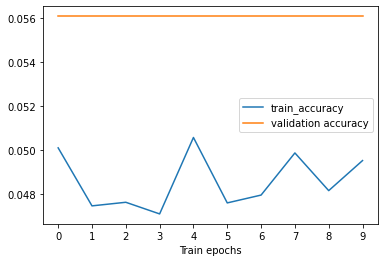

Taining time is 31.7 in seconds. Total trainable parameters are: 86037. Test accuracy: 0.0590


In [201]:
def train_and_evaluate(hidden_layer_sizes=[],
                       activation='tanh',
                       optimizer='Adam',
                       learning_rate=0.01,
                       num_epochs=10,
                       batch_size= 1000):
  """ train and evaluate"""
  start_line = f'Hidden_layer:{hidden_layer_sizes}\\Activation:{activation}\\Optimizer:{optimizer}\\batch_size:{batch_size}\\Learning_Rate: {learning_rate}\\ epochs:{num_epochs}'
  print(f'******************************************')
  print(f'\n\nTrain and Evaluate with: {start_line}')

  start_time = time.time()
  # Build the model.
  model = build_model(n_classes=21,
                      hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      learning_rate=learning_rate)

  # Train the model.
  history = model.fit(
    x=X_train,
    y=y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_split=0.1,
    verbose=0)

  # Retrieve the training metrics (after each train epoch) and the final test
  # accuracy.
  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  plt.plot(train_accuracy, label='train_accuracy')
  plt.plot(val_accuracy, label='validation accuracy')
  plt.xticks(range(num_epochs))
  plt.xlabel('Train epochs')
  plt.legend()
  plt.show()

  test_accuracy = model.evaluate(x=X_test, y=y_test, verbose=0,
                                 return_dict=True)['accuracy']
  total_train_param = sum(count_params(layer) for layer in model.trainable_weights)
  
  time_elapsed = round(time.time() - start_time, 1)
  print(f'Taining time is {time_elapsed} in seconds. Total trainable parameters are: {total_train_param}. Test accuracy: %1.4f' %test_accuracy)

  return test_accuracy

# print('Test Accuracy: %1.4f' %train_and_evaluate())

run_1 = train_and_evaluate()

### Run experiments 

In [ ]:
hidden_sizes =[[],[1024, 512],[2048,1024, 512]]
activation =['tanh','relu']
# optimizer = ['SGD','Adam']
optimizer = ['Adam']
num_epochs= [10, 20]
batch_size= [1000, 2000]

for i in hidden_sizes:
    for a in activation:
        for o in optimizer:
            for n in num_epochs:
                for b in batch_size:
                    train_and_evaluate(hidden_layer_sizes=i,
                                       activation=a,
                                       optimizer=o,
                                       learning_rate=0.01,
                                       num_epochs=n,
                                      batch_size=b)   

### Experiment CNN Model

In [117]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(
    filters=32, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    data_format='channels_last',
    name='conv_1', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_1'))
    
model.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    name='conv_2', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))

model.compute_output_shape(input_shape=(16, 32, 128, 1))

model.add(tf.keras.layers.Flatten())

# chose 16 arbitrarily as the batch dimension
model.compute_output_shape(input_shape=(16, 32, 128, 1))

model.add(tf.keras.layers.Dense(
    units=1024, name='fc_1', 
    activation='relu'))

model.add(tf.keras.layers.Dropout(
    rate=0.5))
    
model.add(tf.keras.layers.Dense(
    units=21, name='fc_2',
    activation='softmax'))

tf.random.set_seed(1)
model.build(input_shape=(None, 32, 128, 1))

model.compute_output_shape(input_shape=(16, 32, 128, 1))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 32, 128, 32)       832       
                                                                 
 pool_1 (MaxPooling2D)       (None, 16, 64, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 16, 64, 64)        51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 8, 32, 64)         0         
                                                                 
 flatten_3 (Flatten)         (None, 16384)             0         
                                                                 
 fc_1 (Dense)                (None, 1024)              16778240  
                                                                 
 dropout_3 (Dropout)         (None, 1024)             

In [120]:
BATCH_SIZE = 1000
NUM_EPOCHS = 20

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) # same as `tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')`

history = model.fit(x=X_train, y=y_train, epochs=NUM_EPOCHS, validation_split=0.1,
#                     validation_data=mnist_valid, 
                    shuffle=True)

Epoch 1/20
3256/3256 [==============================] - 497s 152ms/step - loss: 4184059966128128.0000 - accuracy: 0.0075 - val_loss: 5828136939814912.0000 - val_accuracy: 0.0017
Epoch 2/20
3256/3256 [==============================] - 23963s 7s/step - loss: 10038924487426048.0000 - accuracy: 0.0069 - val_loss: 12980695764828160.0000 - val_accuracy: 0.0017
Epoch 3/20
 163/3256 [>.............................] - ETA: 7:50 - loss: 14452977267900416.0000 - accuracy: 0.0048

KeyboardInterrupt: 

In [ ]:
#graph the loss and accuracy curves of train and validation data
hist_cnn = history.history
x_arr = np.arange(len(hist_cnn['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist_cnn['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist_cnn['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist_cnn['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist_cnn['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/15_12.png', dpi=300)
plt.show()




In [ ]:
test_results = model.evaluate(X_test.batch(20))
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

In [ ]:
batch_test = next(iter(X_test.batch(12)))

preds = model(batch_test[0])

tf.print(preds.shape)
preds = tf.argmax(preds, axis=1)
print(preds)

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = batch_test[0][i, :, :, 0]
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, '{}'.format(preds[i]), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
#plt.savefig('figures/15_13.png', dpi=300)
plt.show()